In [1]:
#libraries to be used later 
import os
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import randint
import subprocess

In [2]:
## we will use a tool called c3d for pre-processing and augmenting MRI images into 3D patches: 
# !wget https://sourceforge.net/projects/c3d/files/c3d/Experimental/c3d-1.1.0-Linux-gcc64.tar.gz 
# !tar -xvzf c3d-1.1.0-Linux-gcc64.tar.gz 

## add to path:
os.environ['PATH'] = os.environ['PATH'] + ':' + os.path.realpath('c3d-1.1.0-Linux-gcc64/bin/')

In [3]:
#defining a function that can help with using c3d which is a comman line based tool 
def c3d(args):
  """ 
  Runs c3d, taking arguments as a single string. 

  Inputs:
    args String: arguments to c3d command as a single string


  Example:

  To get usage info:
  > c3d('-h') 

  To get usage for a specific command:
  > c3d('-h extract-patches')

  """
  list_args = args.split(' ')
  print(list_args)
  cmd_list = ['c3d'] + list_args
  try:
    output = subprocess.check_output(cmd_list,
                                     stderr=subprocess.STDOUT)
  except subprocess.CalledProcessError as e:
    print(e.output.decode('utf-8'))
  else:
    print(output.decode("utf-8"))

In [9]:
#hyperparameters
batch_size = 10
frequency = 1 #sample 1 patch for every K voxels;
#image data gen to read array generator from c3d*
patch_radius= np.array([31,31,31]) #in voxels -- patch will be shape: 1+2*radius

#3D rotation augmentation; only for training set
num_augment = 5 #number of augmentations per patch
angle_stdev = 30 #stdev of normal distribution for sampling angle (in degrees)

#sampling radius
radius = patch_radius 

num_channels = 2 #to indicate that there is an accoriated distance map (in this case AFIDs distance map) --- allows for correct mapping between sampled patch and its corresponding distance map
#creating sampling radius argument (R0xR1xR2)
radius_arg = 'x'.join([str(rad) for rad in radius])

#patch shape = 1+2*radius
dims = 1+2*radius 

k = -2

In [6]:
list_sub = []
with open('/home/ROBARTS/ataha/graham/projects/ctb-akhanf/ataha24/AFIDs_NN/clinical/participants.txt', 'r') as file:
    for subject in file: 
        list_sub.append(subject.strip())

#inputs: t1w images and fcsv files 
mri_images_clinical= sorted(glob('/home/ROBARTS/ataha/graham/projects/ctb-akhanf/ataha24/AFIDs_NN/clinical/derivatives/freesurfer/*/mri/brainmask.nii'))
fcsv_gt = (sorted(glob('/home/ROBARTS/ataha/graham/projects/ctb-akhanf/ataha24/AFIDs_NN/clinical/derivatives/afids_groundtruth/*/*.fcsv')))
path_c3d = '/home/ROBARTS/ataha/graham/projects/ctb-akhanf/ataha24/AFIDs_NN/clinical/derivatives/c3d'

In [39]:
# select afids 

creating masks, probablity maps, etc 0
for i,csv in enumerate(fcsv_gt):
  if (os.path.isdir(f'{path_c3d}/{list_sub[i]}'))== False: 
      !mkdir {path_c3d}/{list_sub[i]} ## creates subject directories within c3d deriv directory
  df = pd.read_table(csv,sep=',',header=2)
  df = df[['x','y','z']]
  df['value'] = 1
  for q in range(0,32):
      np.savetxt(f'{path_c3d}/{list_sub[i]}/{q}.txt', df.iloc[[q]].values) #reads .fcsv files for selected AFIDs and creates txt file for c3d 
      c3d (f'{mri_images_clinical[i]} -scale 0 -landmarks-to-spheres {path_c3d}/{list_sub[i]}/{q}.txt 1 -o {path_c3d}/{list_sub[i]}/{q}.nii') #uses the landmark file to create a thresthold image
      c3d (f'{path_c3d}/{list_sub[i]}/{q}.nii -sdt -o {path_c3d}/{list_sub[i]}/{q}_prob.nii') #uses threthold image to create needed Euclidean distance map 
      c3d (f'{path_c3d}/{list_sub[i]}/{q}_prob.nii -scale {k} -exp -o {path_c3d}/{list_sub[i]}/{q}_prob_norm.nii') #normalizes map such that data follows e^-kx distribution
      c3d (f'{mri_images_clinical[i]} -binarize -o {path_c3d}/{list_sub[i]}/bin.nii') #creates a whole brain mask to sample 3D paches from

In [5]:
## all afids  

#creating masks, probablity maps, etc 0
for i,csv in enumerate(fcsv_gt):
  if (os.path.isdir(f'{path_c3d}/{list_sub[i]}'))== False: 
      !mkdir {path_c3d}/{list_sub[i]} ## creates subject directories within c3d deriv directory
  df = pd.read_table(csv,sep=',',header=2)
  df = df[['x','y','z']]
  df['value'] = 1
  np.savetxt(f'{path_c3d}/{list_sub[i]}/all.txt', df.values) #reads .fcsv files for selected AFIDs and creates txt file for c3d 
  c3d (f'{mri_images_clinical[i]} -scale 0 -landmarks-to-spheres {path_c3d}/{list_sub[i]}/all.txt 1 -o {path_c3d}/{list_sub[i]}/all.nii') #uses the landmark file to create a thresthold image 
  c3d (f'{path_c3d}/{list_sub[i]}/all.nii -sdt -o {path_c3d}/{list_sub[i]}/all_prob.nii') #uses threthold image to create needed Euclidean distance map 
  c3d (f'{path_c3d}/{list_sub[i]}/all_prob.nii -scale {k} -exp -o {path_c3d}/{list_sub[i]}/all_prob_norm.nii') #normalizes map such that data follows e^-kx distribution
  c3d (f'{mri_images_clinical[i]} -binarize -o {path_c3d}/{list_sub[i]}/bin.nii') #creates a whole brain mask to sample 3D paches from

In [8]:
#extracting training data AFIDs maps and masks created in previous block

mask_all = sorted(glob(f'{path_c3d}/*/all.nii')) #stripped brain binary image or afids 

#channels to sample in common with MRI image 
afids= sorted(glob(f'{path_c3d}/*/all_prob_norm.nii'))

input_images = mri_images_clinical #list of input images
sampling_space = mask_all #c3d samples common ground voxels of this mask with the two others below it 

# -------------------------------------------------------------
for i,(img,map1,mask) in enumerate(zip(input_images,afids,sampling_space)):
  print(i)
  c3d(f'{img} {map1} {mask} -xpa {num_augment} {angle_stdev} -xp patch_{i}_31_afids.dat {radius_arg} {frequency}')
  !rm {path_c3d}/{list_sub[i]}/patch_{i}_31_afids.dat
  !mv patch_{i}_31_afids.dat {path_c3d}/{list_sub[i]}

In [17]:
# splitting data into train, test, and val 
# np.random.shuffle(list_sub)

train_sub = list_sub[0:28] #28
val_sub = list_sub[28:34] 
test_sub = list_sub[34:]

In [18]:
#will use this to create paths to train, validation, and test data
import io 
import sys

old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout
print(*train_sub,sep=',')
train = new_stdout.getvalue()
sys.stdout = old_stdout
x = '{'+train.rstrip()+'}'

In [19]:
x

'{sub-087,sub-093,sub-103,sub-106,sub-107,sub-113,sub-115,sub-116,sub-118,sub-120,sub-122,sub-124,sub-125,sub-126,sub-127,sub-128,sub-131,sub-132,sub-133,sub-135,sub-136,sub-138,sub-139,sub-141,sub-145,sub-146,sub-147,sub-148}'

In [21]:
!cat {path_c3d}/{x}/patch_*_31_afids.dat > {path_c3d}/all_patches_train_afids.dat

In [10]:
#exporting the patches into np.array

#read patches in numpy array 
fname = f'{path_c3d}/all_patches_train_afids.dat'

bps = 4 * num_channels * np.prod(dims)         # Bytes per sample
file_size = os.path.getsize(fname) 
num_samples = np.floor_divide(file_size,bps)              # Number of samples
print(file_size)
print(bps)
print(num_samples)

dims = dims.astype('int')
arr_shape_train = (int(num_samples),dims[0],dims[1],dims[2],num_channels)

arr_train = np.memmap(fname,'float32','r',shape=arr_shape_train)
print(arr_shape_train)

45812611152
2000376
22902
(22902, 63, 63, 63, 2)


In [23]:
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout
print(*val_sub,sep=',')
val = new_stdout.getvalue()
sys.stdout = old_stdout
x = '{'+val.rstrip()+'}'

In [24]:
# to check if val path created properly 
x

'{sub-149,sub-150,sub-151,sub-152,sub-153,sub-156}'

In [25]:
#exporting the validation patches into np.array
!cat {path_c3d}/{x}/patch_*_31_afids.dat > {path_c3d}/all_patches_val_31_afids.dat

In [11]:
#read patches in numpy array 
fname_val = f'{path_c3d}/all_patches_val_31_afids.dat'
file_size_val = os.path.getsize(fname_val) 
num_samples_val = np.floor_divide(file_size_val,bps)              # Number of samples
print(file_size_val)
print(num_samples_val)

arr_shape_val = (int(num_samples_val),dims[0],dims[1],dims[2],num_channels)

arr_val = np.memmap(fname_val,'float32','r',shape=arr_shape_val)
print(arr_val.shape)

9337755168
4668
(4668, 63, 63, 63, 2)


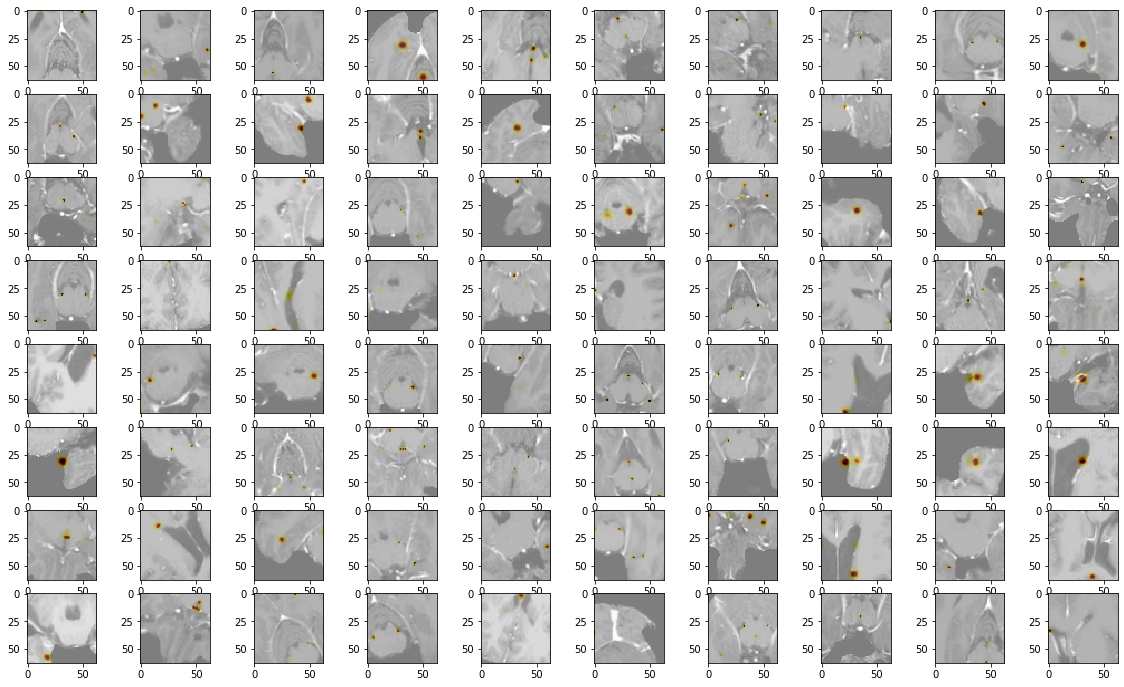

In [13]:
#Plot training patches with overlay at random images and samples:
plt.figure(figsize=(20,12))
nrows=8
ncols=10
for i,randi in enumerate(randint(low=0,high=arr_train.shape[0],size=(nrows*ncols,))):
  plt.subplot(nrows,ncols,i+1)
  plt.imshow(np.squeeze(arr_train[randi,:,40,:,0]),cmap='gray')
  plt.imshow(np.squeeze(arr_train[randi,:,40,:,1]),alpha=0.5,cmap="hot_r")